<h1>Group 1 - Data Collection<span class="tocSkip"></span>

# Introduction

One of the sources we need to scrap was the Youtube website. This notebook contains the code to retrieve the data and also the Robot to retrieve the data once a week. we are scraping the comments and all the information about the videos.
V0 : basic scrap

V1 : add comment, number of Like and  Dislike, scroll function, fills a json file based on a template.  

V2 : add research equation, function which transform the results based on a typology. 

V3 : test of previous function in the srap

V4 : add the quality on the notebook

V5 : test code and correction error

V6 : add translation

V7 : improve date of publication by creating a function

V8 : change chromedriver to phantomJS

V9 : optimizes and corrects errors 

V10 : optimizes and corrects errors 

V11 : final scrap

# Environment

## Libraries

In [1]:
import json
import re
from datetime import datetime, timedelta,date
import time
import requests
from urllib.request import Request, urlopen
from textblob import TextBlob
from langdetect import detect
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import numpy as np
import pandas as pd

In [2]:
#path phantomJS
path = '/home/sid2019-13/Téléchargements/phantomjs-2.1.1-linux-x86_64/bin/phantomjs'

## Data Loading


## Functions

This part contains all the functions we developped during the project

In [3]:
def translate (text) : 
    """Documentation    
       Parameters:
            text : character string 
       out : 
            text : text translated in english
    """
    try :
        new = str(TextBlob(text).translate(to='en'))
        return new
    except :
        return text
    
def replace_all(text, dic):
    """Documentation    
       Parameters:
            text : character string
            dic : dictionary which contains the changes to be made
       out : 
            text : text with all changes made 
    """
    for i, j in dic.items():
        text = text.replace(i, j)
    return text

# Create equation research

In [4]:
Airline_Companies = [
    "American Airlines",
    "Air Canada",
    "Air France",
    "Air Algerie",
    "Air India",
    "Aerolineas Argentinas",
    "Royal Air Maroc",
    "Finnair",
    "Alitalia ",
    " Nouvelair",
    "Air China",
    "Cathay Pacific",
    "Delta Airlines",
    "Aer Lingus",
    "Emirates",
    "Ethiopian Airlines",
    "Icelandair",
    "Hawaiian Airlines",
    "Iberia",
    "Meridiana",
    "Japan Airlines",
    "KLM",
    "Air Malta",
    "Lan Airlines",
    "Luxair",
    "LIAT",
    "LOT Polish Airlines",
    "Air Madagascar",
    "Air Mauritius",
    "Austrian Airlines",
    "Qatar Airways",
    "South African Airways",
    "SAS Scandinavian Airlines",
    "Brussels Airlines",
    "Singapore Airlines",
    "Corsair",
    "Aeroflot",
    "Thai Airways",
    "Turkish Airlines",
    "TAP Portugal",
    "Air Transat",
    "Tunisair",
    "Air Caraibes",
    "United Airlines",
    "Air Austral",
    "Air Europa",
    "Easyjet",
    "Vietnam Airlines",
    "Virgin Atlantic",
    "Air Corsica",
    "Condor",
    "Flybe",
    "Aegean Airlines",
    "Air Tahiti Nui",
    "Aigle Azur",
    "HOP!",
    "Jet Airways",
    "Etihad Airways",
    "Etihad Airways",
    "Oman Air",
    "XL Airways",
    "Ryanair LTD",
    "Vueling ",
    "Norwegian",
    "Transavia France",
    "Germanwings",
    "TUI Fly Belgium",
    "Air Arabia",
    "WOW air",
    "Wizz Air",
    "Air Asia",
    "Volotea",
    "southwest airlines"
]
Airline_Companies = [compagnies.replace(
    ' ', '+') for compagnies in Airline_Companies]


Boeing_Models = [
    "Boeing 717",
    "Boeing 727",
    "Boeing 737-200",
    "Boeing 737-300",
    "Boeing 737-400",
    "Boeing 737-500",
    "Boeing 737-600",
    "Boeing 737-700",
    "Boeing 737-700ER",
    "Boeing 737-800",
    "Boeing 737-900",
    "Boeing 737-900ER",
    "Boeing 737 MAX 7",
    "Boeing 737 MAX 8",
    "Boeing 737 MAX 9",
    "Boeing 737 MAX 10",
    "Boeing 747-200",
    "Boeing 747-400",
    "Boeing 757-200",
    "Boeing 757-300",
    "Boeing 767-200",
    "Boeing 767-300",
    "Boeing 767-300ER",
    "Boeing 767-400ER",
    "Boeing 777 Triple Seven",
    "Boeing 787 DreamLiner"
]
Boeing_Models = [models.replace(' ', '+') for models in Boeing_Models]


Airbus_Models = [
    "A300",
    "A300-600ST",
    "A318",
    "A319",
    "A320-100",
    "A320-200",
    "A320neo",
    "A321-100",
    "A321-200",
    "A330-200",
    "A330-300",
    "A330-200F",
    "A330-500",
    "A340-200",
    "A340-300",
    "A340-500",
    "A340-600",
    "A350-900",
    "A350-1000",
    "A380-800",
    "A220-300"
]

key_words = [
    "trip",
    "fly",
    "plane",
    "airplane",
    "flight"
]


equations = []
for comp in Airline_Companies:
    for mod in Airbus_Models:
        equations.append(comp+"+"+mod)
    for mod in Boeing_Models:
        equations.append(comp+"+"+mod)

# quibbling function

In [9]:
def ChangeDate(chain):
    """Documentation    
       Parameters:
            chain : character string in format "ex :il ya 300 ans"    
       out : 
            expression.group(0) : character string in format  "ex 300 ans"          
    """
    expression = re.search("[0-9]*\s[a-zA-Z]*$", chain)
    return(expression.group(0))


def Simplification(chain):
    # transform M into 1000000,  and K into 1000
    """Documentation    
       Parameters:
            chain : character string in format "ex : 300K"    
       out : 
            int(float(expression) * coef) : integer  "ex 300 000"          
    """
    chain = chain.replace(',', '.')
    if '.' in chain:
        expression = (re.search("\d+\.\d+", chain)).group(0)
    else:
        expression = (re.search("\d+", chain)).group(0)
    coef = 1
    if 'k' in chain:
        coef = 1000
    if 'M' in chain:
        coef = 1000000
    return(int(float(expression) * coef))


def DateCalculation(chain):
    # calculate the exact date of publication of the video
    """Documentation    
       Parameters :
            chain : character string in format "ex : il ya 300 ans"    
       out : 
            chain : date           
    """

    chain = (chain).replace('il y a ', '')
    day_nb=0
    if 'hier' in chain:
        day_nb = 1
    else:
        day_nb = int((re.search("\d+", chain)).group(0))
    if 'mois' in chain:
        day_nb = day_nb * 30
    if 'an' in chain:
        day_nb = day_nb * 365
    if 'semaine' in chain:
        day_nb = day_nb * 7

    now = date.today()
    return str(now - timedelta(days=(day_nb)))

# Creation of the url list

In [12]:
def URLlist(Research_Equations,take7days : bool):
    # returns the list of videos of the search equation passed in parameter
    """Documentation    
       Parameters:
            Research_Equations : search equation we want to launch    
       out : 
            list_Videos : search equation videos list        
    """
    root_URL = "https://www.youtube.com/results?search_query="
    #ResearchEquations = "airbus+A380"
    
    if take7days is True :
        r = requests.get(root_URL + Research_Equations + '&sp=EgIIAw%253D%253D')
    else :
        r = requests.get(root_URL + Research_Equations)
    page = r.text
    soup = BeautifulSoup(page, 'html.parser')
    list_Videos = []
    for videos in soup.findAll('a', attrs={'class': 'yt-uix-tile-link'}) : 
        list_Videos.append('https://www.youtube.com'+videos['href'])
    
    return list_Videos


list_Videos = []
for Equation in equations:
    list_Videos += URLlist(Equation,True)
list_Videos = np.unique(list_Videos)

# Function that creates our filled Json file

In [77]:
def GetCodeHTML(URL_list, fig):
    """Documentation    

       Parameters:
            URL_list : list of url   
            fig : url index processed
       out :  
            BeautifulSoup(web_page, 'html.parser') : return html code of the url page      
    """
    url = URL_list[fig]
    req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})
    web_page = urlopen(req).read()
    time.sleep(2)
    return BeautifulSoup(web_page, 'html.parser')


def CreateJs(comment, nb_com, soup, comment_date,df):
    # create the json file with all the information on the page
    """Documentation    

       Parameters:
            df : dataframe
            comment : character string of the comment
            nb_com : number of comment
            comment_date : comment date
            soup : hltm code of the video
        out :
            df : dataframe

    """
    name_col = ['Data_Source',
            'Airline_Name',
            'Airline_Type',
            'Region_Operation',
            'Aircraft_Type',
            'Cabin_Class',
            'Type_Of_Lounge',
            'Type_Of_Traveller',
            'Date_Visit','Date_Flown',
            'Airport','Route',
            'Category',
            'Category_Detail',
            'Cabin_Staff_Service',
            'Lounge_Staff_Service',
            'Bar_And_Beverages',
            'Food_And_Beverages',
            'Ground_Service',
            'Catering',
            'Cleanliness',
            'Lounge_Comfort',
            'Aisle_Space',
            'Wifi_And_Connectivity',
            'Inflight_Entertainment',
            'Viewing_Tv_Screen',
            'Power_Supply',
            'Seat',
            'Seat_type',
            'Seat_Comfort',
            'Seat_Legroom',
            'Seat_Storage',
            'Seat_Width',
            'Seat_Recline',
            'Washrooms',
            'Value_For_Money',
            'Overall_Customer_Rating',
            'Overall_Service_Rating',
            'Overall_Airline_Rating',
            'Recommended',
            'Date_Review',
            'Review',
            'Departure_city',
            'Arrival_city',
            'Nb_bus_taken',
            'Nb_train_taken',
            'Nb_car_taken',
            'Nb_plane_taken',
            'Duration',
            'Price_min',
            'Price_max',
            'Title',
            'Author',
            'Description',
            'Date_publication',
            'View_Count',
            'Likes',
            'Dislikes',
            'Nb_subscribers',
            'Nb_comments',
            'Nb_sharing',
            'Hashtags',
            'Awards',
            'Registration',
            'Location',
            'Contributions_Pers',
            'Nb_pertinent_comments_Pers',
            'Queuing_Times',
            'Terminal_Seating',
            'Terminal_Signs',
            'Airport_Shopping',
            'Experience_At_Airport']

    soup = soup
    

    video_details = {}
    
    for i in name_col : 
        video_details[i] = None

# Fill data

    video_details['Data_Source'] = 'Youtube'


    video_details['Date_Review'] = DateCalculation(comment_date)
    video_details['Review'] = translate(comment)


# get the title of the video
    if soup.find('span', attrs={'class': 'watch-title'}) == None :
         video_details['Title'] = None
    else :
        video_details['Title'] = soup.find(
            'span', attrs={'class': 'watch-title'}).text.strip()

# get the name of the chain
    if soup.findAll('script', attrs={'type': 'application/ld+json'}) == None :
        video_details['Author'] = None
    else :
        for script in soup.findAll('script', attrs={'type': 'application/ld+json'}):
            channelDescription = json.loads(script.text.strip())
            video_details['Author'] = channelDescription['itemListElement'][0]['item']['name']

# get description
    if soup.find('p', attrs={'id': "eow-description"}) == None :
        video_details['Description'] = None
    else :
        video_details['Description'] = soup.find(
            'p', attrs={'id': "eow-description"}).text.strip()

# get the date of publication
    dic = {'.':'','avr':'apr','janv':'jan','mars':'mar','mai':'may','juin':'jun','févr':'feb','juil':'jul','déc':'dec','août':'aug','sept':'sep','aoÃ»t':'aug','dÃ©c':'dec'}
    if soup.find('strong',attrs={'class': "watch-time-text"}) == None :
        var_date_of_public = ''
    else :
        var_date_of_public = soup.find('strong',attrs={'class': "watch-time-text"}).text.strip().replace('.','')
    var_date_of_public = replace_all(var_date_of_public,dic)
    var_date_not_None = re.search("[0-9][0-9]* [a-zA-Z]* [0-9]*", var_date_of_public)
    if var_date_not_None == None :
        video_details['Date_publication'] = None
    else :
        video_details['Date_publication'] = str(datetime.strptime(var_date_not_None.group(0), '%d %b %Y')). replace('00:00:00', '')

# get the number of views
    if soup.find('div', attrs={'class': 'watch-view-count'}) == None :
        video_details['View_Count'] = None
    else :
        video_details['View_Count'] = (soup.find(
            'div', attrs={'class': 'watch-view-count'}).text.strip()).replace('vues', '')

# get a likes button
    if soup.findAll('', attrs={'class': "yt-uix-button yt-uix-button-size-default yt-uix-button-opacity yt-uix-button-has-icon no-icon-markup like-button-renderer-like-button like-button-renderer-like-button-unclicked yt-uix-clickcard-target yt-uix-tooltip"}) == None:
        video_details['Likes'] = None
    else :
        for span in soup.findAll('', attrs={'class': "yt-uix-button yt-uix-button-size-default yt-uix-button-opacity yt-uix-button-has-icon no-icon-markup like-button-renderer-like-button like-button-renderer-like-button-unclicked yt-uix-clickcard-target yt-uix-tooltip"}):
            video_details['Likes'] = span.find(
                'span', attrs={'class': 'yt-uix-button-content'}).text.strip()

# get a dislikes button
    if soup.findAll('button', attrs={'class': "yt-uix-button yt-uix-button-size-default yt-uix-button-opacity yt-uix-button-has-icon no-icon-markup like-button-renderer-dislike-button like-button-renderer-dislike-button-unclicked yt-uix-clickcard-target yt-uix-tooltip"}) == None:
        video_details['Dislikes'] = None
    else :
        for button in soup.findAll('button', attrs={'class': "yt-uix-button yt-uix-button-size-default yt-uix-button-opacity yt-uix-button-has-icon no-icon-markup like-button-renderer-dislike-button like-button-renderer-dislike-button-unclicked yt-uix-clickcard-target yt-uix-tooltip"}):
            video_details['Dislikes'] = button.find(
                'span', attrs={'class': 'yt-uix-button-content'}).text.strip()

# get subscriber number
    if (soup.find('span', attrs={'class': 'yt-subscription-button-subscriber-count-branded-horizontal yt-subscriber-count'}) == None):
        video_details["Nb_subscribers"] = 0
    else:
        video_details["Nb_subscribers"] = Simplification(soup.find('span', attrs={
                                                         'class': 'yt-subscription-button-subscriber-count-branded-horizontal yt-subscriber-count'}).text.strip())

    video_details['Nb_comments'] = (nb_com).replace('commentaires', '')

# get hashtags
    hashtags = []

    for span in soup.findAll('span', attrs={'class': 'standalone-collection-badge-renderer-text'}):
        for a in span.findAll('a', attrs={'class': 'yt-uix-sessionlink'}):
            hashtags.append(a.text.strip())
    video_details['hashtags'] = hashtags

    
    video_details['Language'] = 'unknown'

    if re.search("([a-z]).*", str(comment).lower()) : 
        try :
            video_details['Language'] = detect(comment)
        except :
            video_details['Language'] = 'unknown'

    if df is None:
        df=pd.DataFrame(columns=list(video_details.keys()))
        df.loc[0,:]=list(video_details.values())
    else:
        df.loc[df.shape[0],:]=list(video_details.values())
    

    return df

def scroll(url, nb_scroll):
    #scroll down in the page
    """Documentation    
       Parameters:
            url : page url 
            nb_scroll : number of times you scroll  
       out : 
            BeautifulSoup(driver.page_source, 'html.parser') : the new page after scroll
            

    """
    options = Options()
    options.add_argument("--start-maximized")
    driver =  webdriver.PhantomJS(path)
    driver.get(url)
    Y = 0
    for _ in range(nb_scroll):
        time.sleep(4)
        driver.execute_script("window.scrollTo("+str(Y)+","+str(Y+800)+")")
        Y += 1200

    return BeautifulSoup(driver.page_source, 'html.parser')

# possible optimisation : 

optimisier la fonction scroll


# Crawl

This part contains the crawl of AirlineQuality website with the execution of all functions 

# global implementation

In [74]:

# Create a new json pour la premiere fois => 
with open('/home/sid2019-13/data.json', 'w', encoding='utf8') as outfile:  json

df= None
for URL_unique in range(len(list_Videos)):
    soup1 = scroll(list_Videos[URL_unique], 4)
    
    SoupCréeJS = GetCodeHTML(list_Videos, URL_unique)
# date comment
    date1 = []
    for span1 in soup1.findAll('span', attrs={'class': "comment-renderer-time"}):
        a = (span1.find('a', attrs={'class': "yt-uix-sessionlink spf-link"}).text.strip())
        date1.append(a)
    date_Track = 0
    for span in soup1.findAll('div', attrs={'class': 'comment-renderer-text-content'}):
        if span.text.strip() != '':
            comment = span.text.strip()
            nb_com = re.search("[0-9][0-9]*", (soup1.find('h2', 
                                                         attrs={'class': 'comment-section-header-renderer'}).text.strip()).replace('\xa0',' ').replace('\u202f','')).group(0)
            df = CreateJs(comment, nb_com, SoupCréeJS, date1[date_Track],df)
            date_Track += 1
    print('vidéo numéro : ', URL_unique, ' fini')
            
df.to_json('/home/sid2019-13/data.json',orient='index')
print('extraction complete')

vidéo numéro :  0  fini
vidéo numéro :  1  fini
vidéo numéro :  2  fini
vidéo numéro :  3  fini
vidéo numéro :  4  fini
vidéo numéro :  5  fini
vidéo numéro :  6  fini
vidéo numéro :  7  fini
vidéo numéro :  8  fini
vidéo numéro :  9  fini
extraction complete


# possible optimisation : 

Étant donnée que nous scrappons pour chaque commentaire d'une même vidéo, les mêmes informations, on pourrait faire en sorte de mettre en paramètre ces informations dans la fonction CreateJS. 



# Descriptive statistics on recovered data

on 30 videos in the last 7 days

In [282]:
import matplotlib.pyplot as plt
import seaborn as sns
path_data ='/home/sid2019-13/Documents/github/ProjetInterpromo2020/Rendu_projet/data_Youtube_sample.json' 
data = pd.read_json(path_data, orient="index")

In [283]:
col_name_use = ['Author','Data_Source','Date_Review','Date_publication','Description','Dislikes','Language',
                'Likes','Nb_comments','Nb_subscribers','Review','Title','View_Count','hashtags'] 
name_col = ['Data_Source','Airline_Name','Airline_Type','Region_Operation', 'Aircraft_Type','Cabin_Class',
            'Type_Of_Lounge','Type_Of_Traveller','Date_Visit','Date_Flown','Airport','Route','Category',
            'Category_Detail','Cabin_Staff_Service','Lounge_Staff_Service','Bar_And_Beverages','Food_And_Beverages',
            'Ground_Service','Catering','Cleanliness','Lounge_Comfort','Aisle_Space','Wifi_And_Connectivity',
            'Inflight_Entertainment','Viewing_Tv_Screen','Power_Supply','Seat','Seat_type','Seat_Comfort',
            'Seat_Legroom','Seat_Storage','Seat_Width','Seat_Recline','Washrooms','Value_For_Money',
            'Overall_Customer_Rating','Overall_Service_Rating','Overall_Airline_Rating','Recommended',
            'Date_Review','Review','Departure_city','Arrival_city','Nb_bus_taken','Nb_train_taken',
            'Nb_car_taken','Nb_plane_taken','Duration','Price_min','Price_max','Title','Author',
            'Description','Date_publication','View_Count','Likes','Dislikes','Nb_subscribers',
            'Nb_comments','Nb_sharing','Hashtags','Awards','Registration','Location','Contributions_Pers',
            'Nb_pertinent_comments_Pers','Queuing_Times','Terminal_Seating','Terminal_Signs','Airport_Shopping',
            'Experience_At_Airport']

# column no used / column used

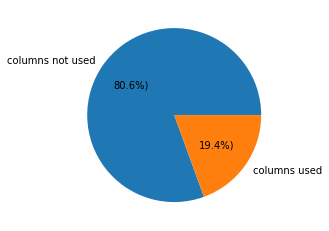

In [284]:
taille = np.array(len(name_col)-len(col_name_use)),(len(col_name_use))
labels= 'columns not used','columns used'
plt.pie(taille,autopct='%1.1f%%)',labels=labels,)
plt.show()

# number of value no null in the column used

<Figure size 432x288 with 0 Axes>

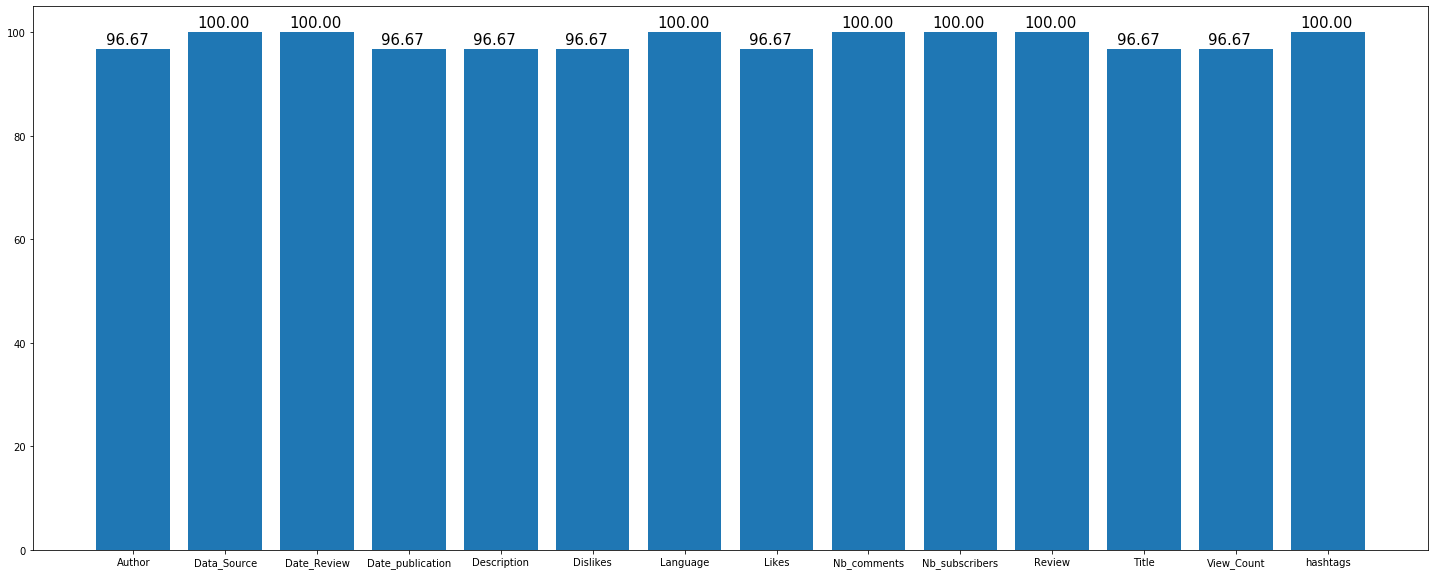

In [285]:
A = data[col_name_use]
resultat = np.array((A.count()*100)/len(data))
x = np.arange(14)

plt.figure()
fig, ax = plt.subplots(figsize= (25,10))
plt.bar(x, resultat)
plt.xticks(x, col_name_use)



x_offset = -0.3
y_offset = 1.00
for p in ax.patches:
    b = p.get_bbox()
    val = "{:.2f}".format(b.y1 + b.y0)        
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset),size = 15)


plt.show()


In [286]:
data['View_Count'] = [str(lv).replace('\xa0','') for lv in data['View_Count']]
data['Likes'] = [str(lv).replace('\u202f','') for lv in data['Likes']]
data['View_Count']= pd.to_numeric(data['View_Count'],downcast = 'integer', errors = 'coerce')
data['Likes'] = pd.to_numeric(data['Likes'],downcast = 'integer', errors = 'coerce')


data[['Likes','Dislikes','Nb_comments','Nb_subscribers','View_Count']].describe()

,Likes,Dislikes,Nb_comments,Nb_subscribers,View_Count
count,58.000000,58.000000,60.000000,60.000000,18.000000
mean,2795.448276,33.637931,262.600000,184860.016667,228.000000
std,2870.377499,35.228925,290.200001,146974.968226,287.605326
min,0.000000,0.000000,1.000000,0.000000,17.000000
25%,38.000000,1.500000,5.000000,3990.000000,40.000000
50%,1451.000000,16.000000,120.000000,180000.000000,68.000000
75%,6636.000000,81.000000,664.000000,364000.000000,275.000000
max,6636.000000,81.000000,664.000000,364000.000000,820.000000
